In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as NF
import torchvision.transforms.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from torchvision.utils import make_grid
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Set device to GPU if available

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

Device: cuda:0


In [3]:
 # Create custom dataset object with images seperated in class specific folders

class CustomDataset(Dataset):
    def __init__(self, class_names, img_dir, transform=None, target_transform=None):
        
        class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
        img_paths = []
        labels = []
        
        for folder in os.listdir(img_dir):
            if folder in class_names:
                label = class_names_label[folder]
            for file in os.listdir(os.path.join(img_dir, folder)):
                img_path = os.path.join(os.path.join(img_dir, folder), file)
                _, file_extension = os.path.splitext(img_path)
                if file_extension == '.jpg':
                    img_paths.append(img_path)
                    labels.append(int(label))
                
        self.img_labels = pd.DataFrame(np.column_stack([img_paths, labels]))
        self.img_paths = img_paths
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        
        return len(self.img_labels)
        
        
    def __getitem__(self, idx):
        
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        image = F.convert_image_dtype(image, dtype=torch.float)
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return (image, label)

In [4]:
class_names = ['berry', 'bird', 'dog', 'flower', 'other']
batch_size = 16

# Add transforms to images to protect against overfitting
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
])

data_path = os.path.expanduser('~') + '/data'

train_set = CustomDataset(class_names, data_path + '/train' , transform=transform)
test_set = CustomDataset(class_names, data_path + '/test')

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

In [5]:
print('Training set has {} instances'.format(len(train_set)))
print('Test set has {} instances'.format(len(test_set)))

print(test_set[0][0].shape)

Training set has 6000 instances
Test set has 2000 instances
torch.Size([3, 32, 32])


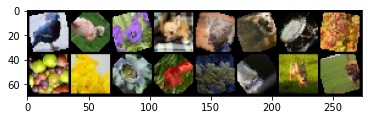

In [6]:
def show_img(image):
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    
dataiter = iter(train_loader)
images, labels = next(dataiter)

image_grid = torchvision.utils.make_grid(images)
show_img(image_grid)

In [7]:
#model = torchvision.models.googlenet(pretrained=True)
#model.to(device)

# PyTorch models inherit from torch.nn.Module
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 8 * 8, 5)

    def forward(self, x):
        x = NF.relu(self.conv1(x))
        x = self.pool1(x)
        x = NF.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 8 * 8)
        x = self.fc1(x)
        return x
    
model = ConvModel()
model.to(device)

ConvModel(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=5, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train_one_epoch(epoch_idx, tb_writer):
    running_loss = 0
    last_loss = 0
    
    for i, data in enumerate(train_loader):
            # Every data instance is an input + label pair
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)

            # Compute the loss and its gradients
            loss = criterion(outputs, labels)
            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data and report
            running_loss += loss.item()
            if i % 1000 == 999:
                last_loss = running_loss / 1000 # loss per batch
                print('  batch {} loss: {}'.format(i + 1, last_loss))
                tb_x = epoch_index * len(training_loader) + i + 1
                tb_writer.add_scalar('Loss/train', last_loss, tb_x)
                running_loss = 0.

    return last_loss

In [10]:
def check_accuracy(loader, model):
    
    if loader == train_loader:
        print("Training set accuracy: ")
    else:
        print("Test set accuracy: ")
        
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = (float(num_correct) / num_samples) * 100.0
        print("Got %d / %d correct (%.2f)" % (num_correct, num_samples, acc))
        
        return acc

In [11]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 1000

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train()
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.eval()

    running_vloss = 0.0
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = model(vinputs)
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    '''# Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    '''

    epoch_number += 1
    
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

EPOCH 1:
LOSS train 0 valid 1.4421542882919312
EPOCH 2:
LOSS train 0 valid 1.3067899942398071
EPOCH 3:
LOSS train 0 valid 1.2410427331924438
EPOCH 4:
LOSS train 0 valid 1.2131870985031128
EPOCH 5:
LOSS train 0 valid 1.1714272499084473
EPOCH 6:
LOSS train 0 valid 1.188240885734558
EPOCH 7:
LOSS train 0 valid 1.1764041185379028
EPOCH 8:
LOSS train 0 valid 1.1574349403381348
EPOCH 9:
LOSS train 0 valid 1.119922399520874
EPOCH 10:
LOSS train 0 valid 1.1066681146621704
EPOCH 11:
LOSS train 0 valid 1.1211364269256592
EPOCH 12:
LOSS train 0 valid 1.1101845502853394
EPOCH 13:
LOSS train 0 valid 1.0887237787246704
EPOCH 14:
LOSS train 0 valid 1.1069138050079346
EPOCH 15:
LOSS train 0 valid 1.0514322519302368
EPOCH 16:
LOSS train 0 valid 1.045033574104309
EPOCH 17:
LOSS train 0 valid 1.0530650615692139
EPOCH 18:
LOSS train 0 valid 1.043262004852295
EPOCH 19:
LOSS train 0 valid 1.0598628520965576
EPOCH 20:
LOSS train 0 valid 1.0290601253509521
EPOCH 21:
LOSS train 0 valid 1.0644394159317017
EPOCH

63.74999999999999

In [12]:
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Training set accuracy: 
Got 3966 / 6000 correct (66.10)
Test set accuracy: 
Got 1275 / 2000 correct (63.75)


63.74999999999999